In [1]:
%pip install telethon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.9/568.9 kB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for telethon: filename=Telethon-1.33.1-py3-none-any.whl size=640890 sha256=1cb31f4978c95cb4bf80d42f12f89532a9b949421cfffedcbed7334718a341ec
  Stored in directory: /root/.cache/pip/wheels/02/0e/09/35784c6ff62f27400f8897c68f38a668038ef6f2df211ac62d
  Created wheel for pyaes: filename=pyaes-1.6.1-py3-none-any.whl size=26346 sha256=75e6414c1ff31070c8fa84d9ea49fb0a47ae9a48b9fa0183d3ed3bfb041b73b0
  Stored in directory: /root/.cache/pip/wheels/d6/84/5f/ea6aef85a93c7e1922486369874f4740a5642d261e09c59140
Successfully built telethon pyaes


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
from telethon import TelegramClient, events, sync

api_id = ""
api_hash = ""
client = TelegramClient(None, api_id, api_hash)
await client.start()

# Начинаем анализировать группу

1. 2. Количество пользователей в группе, выбор группы

In [4]:
group_link = 'https://t.me/rucodechat'

users = await client.get_participants(group_link)
print('Кол-во пользователей', len(users))

Кол-во пользователей 1639


3. Число пользователей с открытым номером телефона

In [ ]:
print(users[0])

User(id=1092286119, is_self=False, contact=True, mutual_contact=True, deleted=False, bot=False, bot_chat_history=False, bot_nochats=False, verified=False, restricted=False, min=False, bot_inline_geo=False, support=False, scam=False, apply_min_photo=True, fake=False, bot_attach_menu=False, premium=False, attach_menu_enabled=False, bot_can_edit=False, close_friend=False, stories_hidden=False, stories_unavailable=True, access_hash=1371121255718181455, first_name='Ваня Бречкин', last_name=None, username='TheGoodest_TheBest', phone='79604805121', photo=UserProfilePhoto(photo_id=5427048730684674358, dc_id=2, has_video=False, personal=False, stripped_thumb=b'\x01\x08\x08\x85\xe4X\xe1Y<\xa4\xc9\x18\x0b\xf4\xefE\x14R\x1bg'), status=UserStatusOffline(was_online=datetime.datetime(2023, 12, 5, 16, 44, 39, tzinfo=datetime.timezone.utc)), bot_info_version=None, restriction_reason=[], bot_inline_placeholder=None, lang_code=None, emoji_status=None, usernames=[], stories_max_id=None, color=None, profil

In [ ]:
phone_access_cnt = 0

for user in users:
  if user.phone != None:
    phone_access_cnt += 1

phone_access_cnt

51

4. Telegram premium

In [ ]:
telegram_premium_owner_cnt = 0

for user in users:
  if user.premium == True:
    telegram_premium_owner_cnt += 1

telegram_premium_owner_cnt

182

5. Статистика имен пользователей

In [ ]:
names = []
for user in users:
  names.append(user.first_name)
names = np.array(names)

df = pd.DataFrame(data=names, columns=['name'])
df.tail()

,name
1641,Виктория
1642,L
1643,Max
1644,Sasha
1645,Vadim


In [ ]:
name_counts = df['name'].value_counts()[:15]  # 15 самых популярных имён
name_counts

Дмитрий      18
Андрей       18
Sergey       17
Alexey       14
Nikita       14
Dmitry       14
Никита       13
Иван         13
Илья         13
Alexander    13
Александр    12
Сергей       11
Vladimir     11
Анастасия    11
Andrey       10
Name: name, dtype: int64

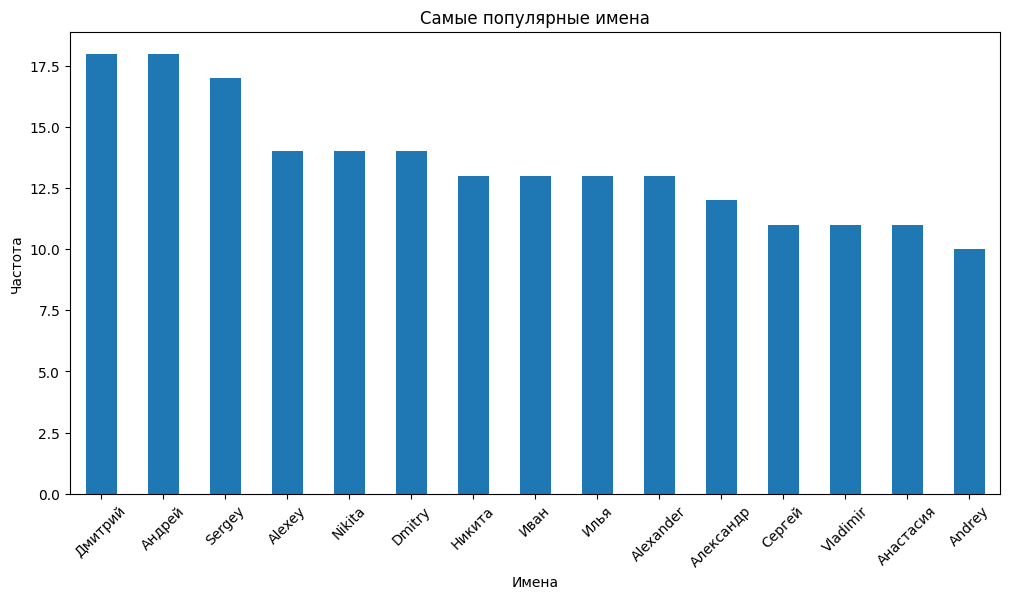

In [ ]:
plt.figure(figsize=(12, 6))
name_counts.plot(kind='bar')
plt.title('Самые популярные имена')
plt.xlabel('Имена')
plt.ylabel('Частота')
plt.xticks(rotation=45)
None

6. Анализ профессий участников на основе раздела "о себе"

In [ ]:
%pip install nltk

Изучим 100 пользователей, так как GetFullUserRequest занимает много времени. \
Upd: Я попробовала взять 100 пользователей, но мне не повезло: заполнено "о себе" было только у 31 из них. Поэтому я попробовала взять 200 человек и надеяться, что во второй раз поведет с шаффлом больше.

In [10]:
from telethon.tl.functions.users import GetFullUserRequest
from random import shuffle

list_about = []
shuffled_users = users[:200]
shuffle(shuffled_users)

for user in shuffled_users:
  full_user = await client(GetFullUserRequest(user.id))
  list_about.append({'about': full_user.full_user.about})

data_about = pd.DataFrame(data=list_about)
data_about.head()

,about
0,None
1,None
2,😅
3,None
4,None


Во второй раз удалось получить 65 людей со статусом..

In [11]:
len(data_about[data_about['about'].notna()])

65

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_nltk = stopwords.words(['russian', 'english']) if 'russian' or 'english' in stopwords.fileids() else None
stopwords_nltk[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

Из тем интересов и сфер работы: \
1. YouTube-каналы, образование \
2. Алмазы в майнкрафте в подарок?? \
3. ML-щики, выкладывают ссылки на github \
4. VK, участники roi, студенты HSE \
5. Developer'ы, студенты


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

about_text_cleaned = data_about['about'].dropna().apply(lambda x: re.sub(r'\W+', ' ', x.lower())).tolist()

vectorizer = CountVectorizer(stop_words=stopwords_nltk, max_features=5000)
X = vectorizer.fit_transform(about_text_cleaned)

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

feature_names = vectorizer.get_feature_names_out()
topics = {}
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    topics[f"Topic {topic_idx}"] = top_features

topics

{'Topic 0': ['канал',
  'немного',
  'com',
  'youtube',
  'andreysozykin',
  'образование',
  'a_sozykin',
  'www',
  'vestacooks',
  'фотки'],
 'Topic 1': ['even',
  'diamond',
  'shape',
  'diamonds',
  'right',
  'minecraft',
  'color',
  'deal',
  'подарит',
  'ищу'],
 'Topic 2': ['https',
  'золото',
  'ing',
  'com',
  'ml',
  'github',
  'sapf3ar',
  'machines',
  'make',
  'see'],
 'Topic 3': ['https',
  'vk',
  '00',
  'ami',
  'shirts',
  'roi',
  'hse',
  'cf',
  'centroidall53608',
  'awardee'],
 'Topic 4': ['https',
  'панки',
  'developer',
  'любят',
  'abiturient',
  'student',
  'systems',
  'technologies',
  'mit',
  'ksu']}

7. Исследование активности пользователей. Кто чаще пишет за последние 500 сообщений

In [ ]:
message_list = []
message_count = {}

messages = await client.get_messages(group_link, 500)

for message in messages:
  sender = await message.get_sender()
  try:
    message_list.append(message.message)
    if message.sender_id not in message_count:
      message_count[message.sender_id] = {'count': 1, 'username': sender.username}
    else:
      message_count[message.sender_id]['count'] += 1
  except AttributeError:
    print(f'User {sender} does not have username')

User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username
User None does not have username


In [ ]:
message_count[6855741398]

{'count': 1, 'username': None}

In [ ]:
message_data = []
for message in message_count.values():
  message_data.append(message)
message_data = pd.DataFrame(data=message_data)

Самые активные: \
Rucode, i_hate_foobar, vesta_ha, TheGoodest_TheBest (мой одногруппник :)), Ilya_Is2022

In [ ]:
message_data.sort_values('count', ascending=False).head()

,count,username
0,136,rucode2023
28,29,i_hate_foobar
19,22,vesta_ha
50,14,TheGoodest_TheBest
10,13,Ilya_Is2022


8. Анализ часто используемых слов в последних 500 сообщениях

In [ ]:
data_message_text = pd.DataFrame(data=message_list, columns=['message'])
data_message_text.tail()

,message
495,"хорошо, спасибо"
496,"Добрый день, дипломов пока нет в личном кабине..."
497,У тебя настолько жёсткий физрук?)
498,А когда будет ответ на вопрос по поводу разряд...
499,Онлайн дипломов нет пока?


Всех интересуют стикеры, МФТИ, где дипломы.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

about_text_cleaned = data_message_text['message'].dropna().apply(lambda x: re.sub(r'\W+', ' ', x.lower())).tolist()

vectorizer = CountVectorizer(stop_words=stopwords_nltk, max_features=5000)
X = vectorizer.fit_transform(about_text_cleaned)

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

feature_names = vectorizer.get_feature_names_out()
topics = {}
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    topics[f"Topic {topic_idx}"] = top_features

topics

{'Topic 0': ['это',
  'стикер',
  'мфти',
  'лет',
  'ии',
  'матери',
  'день',
  'года',
  'детей',
  '2023'],
 'Topic 1': ['онлайн',
  'дипломы',
  'участников',
  'rucode',
  'это',
  'будут',
  'какие',
  'чата',
  'призы',
  'правил'],
 'Topic 2': ['это',
  'rucode',
  'онлайн',
  'мфти',
  'диплом',
  'ещё',
  'место',
  'ит',
  'получат',
  'участники'],
 'Topic 3': ['данные',
  'это',
  'мск',
  'rucode',
  'пока',
  'стикер',
  '18',
  '00',
  'группы',
  'лекция'],
 'Topic 4': ['добрый',
  'день',
  'ноября',
  'пожалуйста',
  'завтра',
  'победителей',
  'это',
  'студентом',
  'участвовать',
  'задачи']}

9. Тенденции в аватарках

In [29]:
files_list = []

for user in users:
  try:
    if user.photo:
      files_list.append(user)
  except ValueError as err:
    print('Error: ', err)

print('Кол-во пользователей с аватарками: ', len(files_list))

Кол-во пользователей с аватарками:  1001


Для просмотра тенденций возьмем 100 рандомных аватарок

In [34]:
# Для удаления фото, если что-то пошло не так
import shutil

shutil.rmtree('./photo')

In [35]:
shuffle(files_list)
for user in files_list[:100]:
  try:
    await client.download_profile_photo(user, f'./photo/{user.id}.jpg')
  except ValueError as err:
    print('Error: ', err)

In [16]:
%pip install imageai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 2.2 MB/s eta 0:00:00


In [36]:
from imageai.Detection import ObjectDetection
import os
import cv2

execution_path = os.getcwd()
print(execution_path)

objects_list = []

for user in files_list:
    files = user.id
    input_file = f'./photo/{files}.jpg'
    if os.path.exists(input_file):
        output_file  = f'./photo/analyse/{files}.jpg'
        output_file2 = f'./photo/analyse/{files}.jpg'
        detector = ObjectDetection()
        detector.setModelTypeAsYOLOv3()
        detector.setModelPath( os.path.join(execution_path , "yolov3.pt"))
        detector.loadModel()
        detections = detector.detectObjectsFromImage(input_image
                                                     =os.path.join(execution_path , input_file),
                                                     output_image_path=
                                                     os.path.join(execution_path , output_file),
                                                     minimum_percentage_probability=30)
        if (len(detections) > 0):
            for eachObject in detections:
                objects_list.append(eachObject["name"])
            image = cv2.imread(output_file)


/content


Посмотрим статистику по найденным объектам. Чаще всего встречается человек, потом стул и кот.

In [38]:
objects_data = pd.DataFrame(data=objects_list, columns=['object'])
objects_data['object'].value_counts()

person         87
chair           7
cat             6
sports ball     4
backpack        4
cell phone      4
umbrella        2
car             2
dog             2
laptop          1
motorbike       1
snowboard       1
frisbee         1
tvmonitor       1
donut           1
horse           1
wine glass      1
apple           1
cup             1
diningtable     1
bench           1
giraffe         1
pizza           1
tie             1
vase            1
Name: object, dtype: int64

# Анализ канала

1. Выбор канала

In [39]:
channel_link = 'https://t.me/t_gen_alg'

In [40]:
channel = await client.get_entity(channel_link)
channel_id = channel.id
print(channel)

Channel(id=1361730051, title='Тинькофф Поколение', photo=ChatPhoto(photo_id=5193210924176092938, dc_id=2, has_video=False, stripped_thumb=b'\x01\x08\x08\xd6$\xfaQE\x14\xac\x07'), date=datetime.datetime(2020, 10, 3, 20, 28, 27, tzinfo=datetime.timezone.utc), creator=False, left=False, broadcast=True, verified=False, megagroup=False, restricted=False, signatures=False, min=False, scam=False, has_link=True, has_geo=False, slowmode_enabled=False, call_active=False, call_not_empty=False, fake=False, gigagroup=False, noforwards=False, join_to_send=False, join_request=False, forum=False, stories_hidden=False, stories_hidden_min=False, stories_unavailable=True, access_hash=1031849877125101914, username='t_gen_alg', restriction_reason=[], admin_rights=None, banned_rights=None, default_banned_rights=None, participants_count=None, usernames=[], stories_max_id=None, color=None)


2. Изучить последние 100 сообщений, найти самый популярный по числу лайков и просмотров

In [41]:
messages = await client.get_messages(channel, limit = 100)

In [42]:
post_list = []

for message in messages:
  reaction = message.reactions
  try:
    reactions_count = sum([reaction.count for reaction in reaction.results])
  except AttributeError as err:
    reactions_count = 0
  try:
    replies_count = message.replies.replies
  except AttributeError as err:
    replies_count = 0
  msg = {'text': message.text, 'views': message.views, 'reactions_count': reactions_count, 'replies_count': replies_count}
  post_list.append(msg)

len(post_list)

100

In [43]:
data_post = pd.DataFrame(data=post_list)
data_post.head()

,text,views,reactions_count,replies_count
0,⚡️В Питере сейчас стартует ВКОШП и NERC. Коман...,976,31,2
1,Всем привет!\nСегодня мы с вами встречаемся на...,1793,30,1
2,⚡️ ⚡️⚡️\nПрямо сейчас проходит [чемпионат](htt...,2339,70,0
3,Всем привет!\nСегодня мы с вами встречаемся на...,3088,26,14
4,1️⃣1️⃣ декабря в 1️⃣8️⃣:0️⃣0️⃣ по адресу Гашек...,6301,30,1


 Самый популрный пост по посмотрам

In [ ]:
data_post.sort_values(by=['views'], ascending=False).head(1)

,text,views,reactions_count
45,"Запись трансляции доступна по ссылке, презента...",8398,52


Самый популярный пост по кол-ву реакций

In [ ]:
data_post.sort_values(by=['reactions_count'], ascending=False).head(1)

,text,views,reactions_count
81,Всем привет!\nЗавтра **11.02.2023** мы с вами ...,5891,1077


3. Пост с наибольшим кол-вом комментариев

In [ ]:
data_post.sort_values(by=['replies_count'], ascending=False).head(1)

,text,views,reactions_count,replies_count
37,Границы проходов в параллели в Москве и онлайн...,7169,122,154


4. Определить самую популярную реакцию

In [ ]:
reaction_list = []

for message in messages:
  try:
    reactions = message.reactions.results
    reaction_dict = {}
    for reaction in reactions:
      reaction_dict[reaction.reaction.emoticon] = reaction.count
    reaction_list.append(reaction_dict)
  except AttributeError as err:
    print(f'Message {message.id} does not have reactions')

data_reaction = pd.DataFrame(data=reaction_list)
data_reaction.head()

Message 270 does not have reactions
Message 266 does not have reactions


,👎,❤,👏,🙏,🤨,👍,🐳,🥰,🍾,😱,...,🤬,🌚,😍,🌭,👌,❤‍🔥,😐,🎉,🏆,💋
0,28.0,21.0,4.0,3.0,3.0,2.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,13.0,3.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,23.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Реакция, которую суммарно ставили чаще всего

In [ ]:
data_reaction.sum().sort_values(ascending=False).head(1)

🕊    1449.0
dtype: float64

5. Самый активный комментатор\
Для каждого поста пройдем по всем ответам на него, и каждому пользователю-комментатору прибавим ответ. Данные храним в словаре {user_id: replies_count} \
В итоге у меня не получилось реализовать, так как async for нельзя вызывать в обычном for.

In [ ]:
replies_count_dict = {}

async def message_reply_iter(message_id):
  async for reply in client.iter_messages(channel_id, reply_to=message_id):
    print(reply)
    if reply.sender_id not in replies_count_dict:
      replies_count_dict[reply.sender_id] = 1
    else:
      replies_count_dict[reply.sender_id] += 1

for message in messages:
  message_reply_iter(message.id)

for user in replies_count_dict:
  print(user)

Message(id=159052, peer_id=PeerChannel(channel_id=1333227456), date=datetime.datetime(2023, 12, 2, 15, 36, 3, tzinfo=datetime.timezone.utc), message='Жить на коленях имба', out=False, mentioned=False, media_unread=False, silent=False, post=False, from_scheduled=False, legacy=False, edit_hide=True, pinned=False, noforwards=False, invert_media=False, from_id=PeerUser(user_id=935597178), fwd_from=None, via_bot_id=None, reply_to=MessageReplyHeader(reply_to_scheduled=False, forum_topic=False, quote=False, reply_to_msg_id=159048, reply_to_peer_id=None, reply_from=None, reply_media=None, reply_to_top_id=159008, quote_text=None, quote_entities=[], quote_offset=None), media=None, reply_markup=None, entities=[], views=None, forwards=None, replies=None, edit_date=datetime.datetime(2023, 12, 2, 15, 38, 21, tzinfo=datetime.timezone.utc), post_author=None, grouped_id=None, reactions=MessageReactions(results=[ReactionCount(reaction=ReactionEmoji(emoticon='👍'), count=1, chosen_order=None)], min=False,

In [ ]:
print(len(replies_count_dict))

0


Анализ текста 3-х самых популярных постов по просмотрам

In [54]:
popular_posts = data_post.sort_values(by=['views'], ascending=False).head(3)
popular_posts

,text,views,reactions_count,replies_count
47,"Запись трансляции доступна по ссылке, презента...",8408,52,28
48,Мы всё-таки решились сделать трансляцию дня от...,8370,50,10
43,Обновили страничку https://algocourses.ru/ 🥳\n...,8055,47,72


In [55]:
about_text_cleaned = popular_posts['text'].apply(lambda x: re.sub(r'\W+', ' ', x.lower())).tolist()

vectorizer = CountVectorizer(stop_words=stopwords_nltk, max_features=5000)
X = vectorizer.fit_transform(about_text_cleaned)

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

feature_names = vectorizer.get_feature_names_out()
topics = {}
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    topics[f"Topic {topic_idx}"] = top_features

topics

{'Topic 0': ['шоколадку',
  'получит',
  'пишите',
  'письмо',
  'паролем',
  'параллель',
  'параллелей',
  'отбора',
  'отбор',
  'описание'],
 'Topic 1': ['ссылке',
  'презентацию',
  'основными',
  'трансляции',
  'тезисами',
  'запись',
  'прикрепляю',
  'доступна',
  'https',
  'youtube'],
 'Topic 2': ['https',
  'дверей',
  'дня',
  'youtube',
  'поста',
  'share',
  'предыдущего',
  'хотите',
  'очно',
  'прийти'],
 'Topic 3': ['ссылке',
  'https',
  'презентацию',
  'основными',
  'трансляции',
  'тезисами',
  'запись',
  'прикрепляю',
  'доступна',
  'youtube'],
 'Topic 4': ['ссылке',
  'https',
  'презентацию',
  'основными',
  'трансляции',
  'тезисами',
  'запись',
  'прикрепляю',
  'доступна',
  'youtube']}

Анализ текста 3-х самых популярных постов по реакциям

In [52]:
popular_posts_r = data_post.sort_values(by=['reactions_count'], ascending=False).head(3)
popular_posts_r

,text,views,reactions_count,replies_count
83,Всем привет!\nЗавтра **11.02.2023** мы с вами ...,5897,1077,2
89,"Наши любимые, невероятные, замечательные дети!...",5483,244,1
41,"Возможно, новое правило прошло немного незамет...",7708,218,80


In [53]:
about_text_cleaned = popular_posts_r['text'].apply(lambda x: re.sub(r'\W+', ' ', x.lower())).tolist()

vectorizer = CountVectorizer(stop_words=stopwords_nltk, max_features=5000)
X = vectorizer.fit_transform(about_text_cleaned)

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

feature_names = vectorizer.get_feature_names_out()
topics = {}
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    topics[f"Topic {topic_idx}"] = top_features

topics

{'Topic 0': ['параллель',
  '11',
  '00',
  'занятие',
  'геометрия',
  'данных',
  'девятнадцатом',
  'завтра',
  'привет',
  'кратчайшие'],
 'Topic 1': ['кому',
  'нами',
  'прога',
  'желанную',
  'замечательные',
  'здоровы',
  'поступить',
  'постом',
  'получать',
  'поздравляем'],
 'Topic 2': ['параллель',
  'экономике',
  'разрешить',
  'немного',
  'новое',
  'обж',
  'математике',
  'отборе',
  'победители',
  'классникам'],
 'Topic 3': ['параллель',
  'экономике',
  'разрешить',
  'немного',
  'новое',
  'обж',
  'математике',
  'отборе',
  'победители',
  'классникам'],
 'Topic 4': ['параллель',
  'экономике',
  'разрешить',
  'немного',
  'новое',
  'обж',
  'математике',
  'отборе',
  'победители',
  'классникам']}